# FGBuster vs FURAX: Framework Comparison for CMB Component Separation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CMBSciPol/furax-compsep-paper/blob/main/notebooks/01_FGBuster_vs_FURAX_Comparison.ipynb)

## Learning Objectives

By the end of this notebook, you will:
- Understand the differences between traditional (FGBuster) and modern (FURAX) component separation frameworks
- See the performance advantages of JAX over NumPy for CMB analysis
- Learn how to implement and benchmark likelihood functions
- Understand automatic differentiation benefits for parameter optimization

## Background

### The Component Separation Problem

CMB observations contain multiple astrophysical components:
- **CMB signal**: What we want to measure
- **Galactic dust**: Modified blackbody emission
- **Synchrotron**: Power-law emission from cosmic rays
- **Instrumental noise**: Detector and systematic effects

The challenge is to separate these components accurately to recover the CMB signal.

In [1]:
import os

os.environ["EQX_ON_ERRORS"] = "nan"
# Core scientific computing
import operator
from functools import partial

# JAX for high-performance computing
import jax
import jax.numpy as jnp
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa: F401

# FGBuster - Traditional component separation framework
from fgbuster import (
    CMB,
    Dust,
    Synchrotron,
    basic_comp_sep,
    get_instrument,
)

# FURAX - Modern JAX-based framework
from furax import HomothetyOperator
from furax.obs.landscapes import Stokes
from furax.obs.operators import (
    CMBOperator,
    DustOperator,
    MixingMatrixOperator,
    SynchrotronOperator,
)

# Set JAX to use 64-bit precision for scientific accuracy
jax.config.update("jax_enable_x64", True)

## Step 1: Generate Simulated Sky Maps

We start by creating realistic CMB and foreground simulations using PySM (Python Sky Model). These simulated observations will serve as our test data for comparing the two frameworks.

### Key Parameters:
- **NSIDE = 64**: HEALPix resolution 
- **Instrument**: LiteBIRD frequency configuration (15 bands: 40-402 GHz)
- **Components**: CMB + dust + synchrotron emission
- **Stokes**: I, Q, U polarization parameters

### Why Use Simulations?
1. **Ground truth**: We know the input parameters
2. **Controlled testing**: Compare framework accuracy
3. **Reproducibility**: Same data for fair comparison

**Note**: On HPC clusters without internet access, these maps are pre-cached using `generate_maps.py`

In [2]:
from furax_cs.data.generate_maps import save_to_cache

nsides = [64]
for nside in nsides:
    save_to_cache(nside)

Loaded freq_maps for nside 64 from cache and noise False.


In [3]:
from furax_cs.data.generate_maps import load_from_cache

nside = 64

nu, freq_maps = load_from_cache(nside)
# Check the shape of freq_maps
print("freq_maps shape:", freq_maps.shape)

Loaded freq_maps for nside 64 from cache.
freq_maps shape: (15, 3, 49152)


## Step 2: Convert Data to FURAX Format

FURAX uses a structured data format called `Stokes` that organizes polarization data (I, Q, U) in a JAX-compatible format. This conversion step is essential for interfacing with FURAX's operator-based architecture.

### Understanding the Data Structure

The frequency maps have shape `(15, 3, 49152)` where:
- **15**: Number of frequency channels (LiteBIRD bands)
- **3**: Stokes parameters (I, Q, U polarization)  
- **49152**: HEALPix pixels (12 × 64² for NSIDE=64)

**Note**: Although FURAX includes its own functions to create sky maps from PySM, we use `fgbuster` here to ensure that both methods receive identical inputs for comparison.

In [4]:
d = Stokes.from_stokes(I=freq_maps[:, 0, :], Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])
d.structure

StokesIQU(i=ShapeDtypeStruct(shape=(15, 49152), dtype=float64), q=ShapeDtypeStruct(shape=(15, 49152), dtype=float64), u=ShapeDtypeStruct(shape=(15, 49152), dtype=float64))

In [5]:
# Component Initialization and Reference Frequencies

# Reference frequencies for component models (in GHz)
dust_nu0 = 150.0  # Dust template frequency - near peak of dust SED
synchrotron_nu0 = 20.0  # Synchrotron template frequency - low frequency where dominant

# Get LiteBIRD instrument specification
instrument = get_instrument("LiteBIRD")

# Define the astrophysical components for separation
# Each component has its own spectral energy distribution (SED)
components = [
    CMB(),  # Blackbody at 2.725K (no free parameters)
    Dust(dust_nu0),  # Modified blackbody (temp, beta_dust)
    Synchrotron(synchrotron_nu0),  # Power law (beta_synchrotron)
]

## Defining the Likelihood Function for Component Separation

In this cell, we define the `negative_log_prob` function, which calculates the negative log-likelihood of observing the given data `d` based on the model parameters.

The likelihood function is based on a quadratic form that includes the mixing matrix `A`, inverse noise covariance `N^{-1}`, and observed data `d`. The key term in the likelihood is:

$$
\left(A^T N^{-1} d\right)^T \left(A^T N^{-1} A\right)^{-1} \left(A^T N^{-1} d\right)
$$

### Explanation of Each Term

1. **$A$**: The mixing matrix operator, which maps the component space to the observed frequency space.
2. **$N^{-1}$**: The inverse of the noise covariance matrix, represented by `invN` in the code.
3. **$d$**: The observed data, which is structured as a `Stokes` in Furax.

### Implementation Details

- **Transposing and Applying `A`**: `A.T(d)` applies the transpose of `A` to `d`, equivalent to the term $A^T d$.
- **Computing the Likelihood**: The quadratic form is computed by applying $A^T N^{-1} d$, inverting $A^T N^{-1} A$, and performing matrix multiplications to evaluate the likelihood.
- **Negative Log-Likelihood**: The final output of `negative_log_prob` is the negative of this log-likelihood value, allowing us to use it as a loss function for optimization.


In [6]:
# Initialize FURAX operators and noise model
invN = HomothetyOperator(
    jnp.ones(1), _in_structure=d.structure
)  # Identity noise (uniform weighting)
DND = invN(d) @ d  # Pre-compute noise-weighted data norm

# Define input structure for component operators
in_structure = d.structure_for((d.shape[1],))  # Structure for pixel-wise operations

# True parameter values from simulation (our target for optimization)
best_params = {"temp_dust": 20.0, "beta_dust": 1.54, "beta_pl": -3.0}

# Reference frequencies (same as component initialization)
dust_nu0 = 150.0
synchrotron_nu0 = 20.0


@jax.jit  # JIT compilation for performance
def negative_log_prob(params, d):
    """
    Compute negative log-likelihood for component separation.

    This function implements the standard CMB likelihood:
    -ln(L) = (d - As)^T N^-1 (d - As) / 2 + const

    For the parametric case where we marginalize over amplitudes s,
    this reduces to the quadratic form shown in the mathematical derivation.
    """
    # Create component operators with current parameter values
    cmb = CMBOperator(nu, in_structure=in_structure)
    dust = DustOperator(
        nu,
        frequency0=dust_nu0,
        temperature=params["temp_dust"],
        beta=params["beta_dust"],
        in_structure=in_structure,
    )
    synchrotron = SynchrotronOperator(
        nu,
        frequency0=synchrotron_nu0,
        beta_pl=params["beta_pl"],
        in_structure=in_structure,
    )

    # Construct mixing matrix A(β) from component operators
    A = MixingMatrixOperator(cmb=cmb, dust=dust, synchrotron=synchrotron)

    # Compute likelihood using the marginalized form:
    # L = (A^T N^-1 d)^T (A^T N^-1 A)^-1 (A^T N^-1 d)
    x = (A.T @ invN)(d)  # A^T N^-1 d
    likelihood = jax.tree.map(lambda a, b: a @ b, x, (A.T @ invN @ A).I(x))
    summed_log_prob = jax.tree.reduce(operator.add, likelihood)

    return -summed_log_prob  # Return negative for minimization

## Performance Analysis: Likelihood and Gradient Evaluation

Now we benchmark the core performance characteristics of our FURAX implementation. This timing analysis is crucial for understanding the computational advantages of the JAX-based approach.

In [7]:
negative_log_prob(best_params, d)

Array(-2.7526803e+13, dtype=float64)

In [8]:
# Evaluate likelihood at true parameters (should be close to optimum)
likelihood_value = negative_log_prob(best_params, d)
print(f"Likelihood at true parameters: {likelihood_value}")

# Performance benchmarking with proper JAX timing (block_until_ready)
print("Performance of the negative log-likelihood evaluation:")
negative_log_prob(best_params, d).block_until_ready()  # Warm-up for JIT
%timeit negative_log_prob(best_params, d).block_until_ready()

print("Performance of the gradient evaluation:")
# JAX automatic differentiation - no manual gradient coding required!
grad_func = jax.grad(negative_log_prob)
grad_func(best_params, d)["beta_pl"].block_until_ready()  # Warm-up
%timeit grad_func(best_params, d)['beta_pl'].block_until_ready()

Likelihood at true parameters: -27526803021880.71
Performance of the negative log-likelihood evaluation:
7.4 ms ± 486 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Performance of the gradient evaluation:
18.9 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Check for Correctness

In this cell, we perform a basic correctness check by comparing the gradients of the negative log-likelihood at two sets of parameters:

1. **Wrong Parameters**: A set of parameters obtained by adding random noise to `best_params`.
2. **Correct Parameters**: The original `best_params`.

By calculating and comparing the gradient magnitudes (using the `max` reduction), we can verify that the gradient at the correct parameters is smaller, indicating proximity to an optimal or near-optimal point.


In [9]:
# Gradient-based correctness validation
# Generate perturbed parameters (intentionally wrong values)
wrong_params = jax.tree.map(lambda x: x + jax.random.normal(jax.random.PRNGKey(0)), best_params)

# Compare gradient magnitudes - smaller gradients indicate proximity to optimum
grad_wrong = jax.tree.reduce(max, jax.grad(negative_log_prob)(wrong_params, d))
grad_correct = jax.tree.reduce(max, jax.grad(negative_log_prob)(best_params, d))

print(f"Gradient magnitude at wrong parameters: {grad_wrong:.2e}")
print(f"Gradient magnitude at correct parameters: {grad_correct:.2e}")
print(f"Ratio (wrong/correct): {abs(grad_wrong / grad_correct):.1e}")

# The much smaller gradient at true parameters confirms our implementation is correct

Gradient magnitude at wrong parameters: -5.01e+08
Gradient magnitude at correct parameters: 7.72e-01
Ratio (wrong/correct): 6.5e+08


## Using FURAX's Built-in Likelihood Functions

Up to this point, we have implemented our own custom likelihood function to understand the underlying mathematics. However, FURAX provides optimized, pre-built likelihood functions that are more robust and efficient for production use.

### Why Use Built-in Functions?

1. **Optimization**: FURAX's built-in functions are heavily optimized with JAX transformations
2. **Robustness**: They include proper error handling and numerical stability checks
3. **Consistency**: Standardized interface across different component separation methods
4. **Maintenance**: Less code to maintain and debug

### Comparing Custom vs Built-in Implementation

Here we demonstrate that our custom implementation produces identical results to FURAX's built-in `negative_log_likelihood` function. This validation ensures our understanding is correct and that we can trust the built-in functions for future work.

In [10]:
from furax.obs import negative_log_likelihood

negative_log_likelihood = partial(
    negative_log_likelihood, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0
)

L = negative_log_likelihood(best_params, nu=nu, N=invN, d=d)

assert jax.tree.all(
    jax.tree.map(lambda x, y: jnp.isclose(x, y, rtol=1e-5), L, negative_log_prob(best_params, d))
)

# Framework Validation: Comparing FURAX and FGBuster

In this section, we validate our FURAX implementation by comparing it to FGBuster's well-established component separation algorithms. This cross-validation is crucial for ensuring that our modern JAX-based approach produces results consistent with the traditional NumPy-based methods.

## The Importance of Cross-Framework Validation

1. **Scientific Rigor**: Ensures our new methods don't introduce systematic biases
2. **Trust Building**: Demonstrates that modern tools preserve scientific accuracy
3. **Method Verification**: Confirms our implementation of component separation is correct
4. **Performance Baseline**: Establishes a reference for speed and accuracy comparisons

## Test Cases: From Simple to Complex

We test both frameworks under increasingly challenging conditions:
- **Case 1**: Optimal starting parameters (convergence test)
- **Case 2**: Single incorrect parameter (robustness test)
- **Case 3**: Multiple incorrect parameters (recovery test)
- **Case 4**: All parameters wrong (optimization challenge)

### Case 1 : Initial Validation: Using `best_params` as the Starting Point

We begin the validation process by setting `best_params` as the initial point for both our custom implementation and FGBuster’s `c1d0s0` model. This allows us to directly compare the outputs and confirm that the models produce similar results when initialized wit


In [11]:
components[1]._set_default_of_free_symbols(beta_d=1.54, temp=20.0)
components[2]._set_default_of_free_symbols(beta_pl=-3.0)

result = basic_comp_sep(components, instrument, freq_maps)
print(result.params)
print(result.x)

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.54 20.   -3.  ]


In [12]:
best_params = {"temp_dust": 20.0, "beta_dust": 1.54}

scipy_solver = jaxopt.ScipyMinimize(fun=negative_log_likelihood, method="TNC", jit=True, tol=1e-10)
result = scipy_solver.run(best_params, nu=nu, N=invN, d=d)
result.params

/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jaxopt/_src/scipy_wrappers.py:341: OptimizeWarning: Unknown solver options: maxiter
  res = osp.optimize.minimize(scipy_fun, jnp_to_onp(init_params, self.dtype),


{'beta_dust': Array(1.6840915, dtype=float64),
 'temp_dust': Array(16.21684079, dtype=float64)}

## Case 2 : Validation with Incorrect Parameter: Setting `beta_dust` to a Wrong Value

In [13]:
components[1]._set_default_of_free_symbols(beta_d=2.54, temp=20.0)
components[2]._set_default_of_free_symbols(beta_pl=-3.0)

result = basic_comp_sep(components, instrument, freq_maps)
print(result.params)
print(result.x)

<lambdifygenerated-9>:2: RuntimeWarning: overflow encountered in power
  return 568.8620443215493*(0.05*nu)**beta_pl*numpy.expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*numpy.expm1(0.3521734047599502)**2)
<lambdifygenerated-9>:2: RuntimeWarning: overflow encountered in power
  return 568.8620443215493*(0.05*nu)**beta_pl*numpy.expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*numpy.expm1(0.3521734047599502)**2)
<lambdifygenerated-10>:2: RuntimeWarning: overflow encountered in power
  return 568.8620443215493*(0.05*nu)**beta_pl*numpy.expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)*log(0.05*nu)/(nu**2*numpy.expm1(0.3521734047599502)**2)


SVD of A failed -> logL = -inf
SVD of A failed -> logL_dB not updated
SVD of A failed -> logL = -inf
SVD of A failed -> logL = -inf
SVD of A failed -> logL = -inf


<lambdifygenerated-9>:2: RuntimeWarning: overflow encountered in multiply
  return 568.8620443215493*(0.05*nu)**beta_pl*numpy.expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*numpy.expm1(0.3521734047599502)**2)


SVD of A failed -> logL = -inf
SVD of A failed -> logL = -inf
SVD of A failed -> logL = -inf
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.53195651 19.97377884 -2.94289685]


In [14]:
params = {"temp_dust": 20.0, "beta_dust": 2.54, "beta_pl": -3.0}

scipy_solver = jaxopt.ScipyMinimize(fun=negative_log_likelihood, method="TNC", jit=True, tol=1e-10)
result = scipy_solver.run(params, nu=nu, N=invN, d=d)
result.params

/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jaxopt/_src/scipy_wrappers.py:341: OptimizeWarning: Unknown solver options: maxiter
  res = osp.optimize.minimize(scipy_fun, jnp_to_onp(init_params, self.dtype),


{'beta_dust': Array(1.5400293, dtype=float64),
 'beta_pl': Array(-2.99971665, dtype=float64),
 'temp_dust': Array(19.99896136, dtype=float64)}

## Case 3 : Setting `beta_dust` and `beta_pl` to Incorrect Values


In [15]:
components[1]._set_default_of_free_symbols(beta_d=2.54, temp=20.0)
components[2]._set_default_of_free_symbols(beta_pl=-6.0)

result = basic_comp_sep(components, instrument, freq_maps)
print(result.params)
print(result.x)

<lambdifygenerated-9>:2: RuntimeWarning: overflow encountered in power
  return 568.8620443215493*(0.05*nu)**beta_pl*numpy.expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*numpy.expm1(0.3521734047599502)**2)
<lambdifygenerated-9>:2: RuntimeWarning: overflow encountered in power
  return 568.8620443215493*(0.05*nu)**beta_pl*numpy.expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*numpy.expm1(0.3521734047599502)**2)
<lambdifygenerated-10>:2: RuntimeWarning: overflow encountered in power
  return 568.8620443215493*(0.05*nu)**beta_pl*numpy.expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)*log(0.05*nu)/(nu**2*numpy.expm1(0.3521734047599502)**2)


SVD of A failed -> logL = -inf
SVD of A failed -> logL_dB not updated
SVD of A failed -> logL = -inf
SVD of A failed -> logL = -inf
SVD of A failed -> logL = -inf
SVD of A failed -> logL = -inf


<lambdifygenerated-9>:2: RuntimeWarning: overflow encountered in multiply
  return 568.8620443215493*(0.05*nu)**beta_pl*numpy.expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*numpy.expm1(0.3521734047599502)**2)


SVD of A failed -> logL = -inf
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.53034371 19.9741819  -5.99474719]


In [16]:
params = {"temp_dust": 20.0, "beta_dust": 2.54, "beta_pl": -6.0}

scipy_solver = jaxopt.ScipyMinimize(fun=negative_log_likelihood, method="TNC", jit=True, tol=1e-10)
result = scipy_solver.run(params, nu=nu, N=invN, d=d)
result.params

/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jaxopt/_src/scipy_wrappers.py:341: OptimizeWarning: Unknown solver options: maxiter
  res = osp.optimize.minimize(scipy_fun, jnp_to_onp(init_params, self.dtype),


{'beta_dust': Array(1.53999422, dtype=float64),
 'beta_pl': Array(-2.9998216, dtype=float64),
 'temp_dust': Array(20.00017662, dtype=float64)}

## Case 4 : Setting All Parameters to Incorrect Values


In [17]:
components[1]._set_default_of_free_symbols(beta_d=2.54, temp=25.0)
components[2]._set_default_of_free_symbols(beta_pl=-6.0)

result = basic_comp_sep(components, instrument, freq_maps)
print(result.params)
print(result.x)

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.53999883 20.00004072 -2.99997694]


# Advanced Optimization with JAX: Using Optax

The JAX ecosystem provides powerful optimization tools through Optax, which offers state-of-the-art optimization algorithms with automatic differentiation support. This demonstrates one of the key advantages of the FURAX framework over traditional approaches.

## Why JAX-based Optimization?

1. **Automatic Differentiation**: No need for manual gradient computation
2. **GPU Acceleration**: Seamless GPU support for large-scale problems
3. **Modern Algorithms**: Access to latest optimization methods (Adam, L-BFGS, etc.)
4. **Composability**: Easy to combine different optimization strategies

## L-BFGS: A Powerful Second-Order Method

L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) is particularly effective for parameter estimation problems because it:
- Uses second-order information (curvature) for faster convergence
- Has limited memory requirements suitable for high-dimensional problems
- Naturally handles the smooth, well-conditioned likelihood surfaces typical in CMB analysis

In [18]:
import optax
import optax.tree_utils as otu
from jax_grid_search import optimize

In [19]:
solver = optax.lbfgs()

params = {"temp_dust": 25.0, "beta_dust": 2.54, "beta_pl": -3.0}

final_params, final_state = optimize(
    params,
    negative_log_likelihood,
    solver,
    max_iter=100,
    tol=1e-4,
    nu=nu,
    N=invN,
    d=d,
    log_updates=True,
)

print(
    f"Final parameters: {final_params}, number of evaluations: {otu.tree_get(final_state, 'count')}"
)
print(f"Initial Value: {negative_log_prob(final_params, d=d)}")

Final parameters: {'beta_dust': Array(1.53999985, dtype=float64), 'beta_pl': Array(-2.99999938, dtype=float64), 'temp_dust': Array(20.00000527, dtype=float64)}, number of evaluations: 30
Initial Value: -27526803021880.71


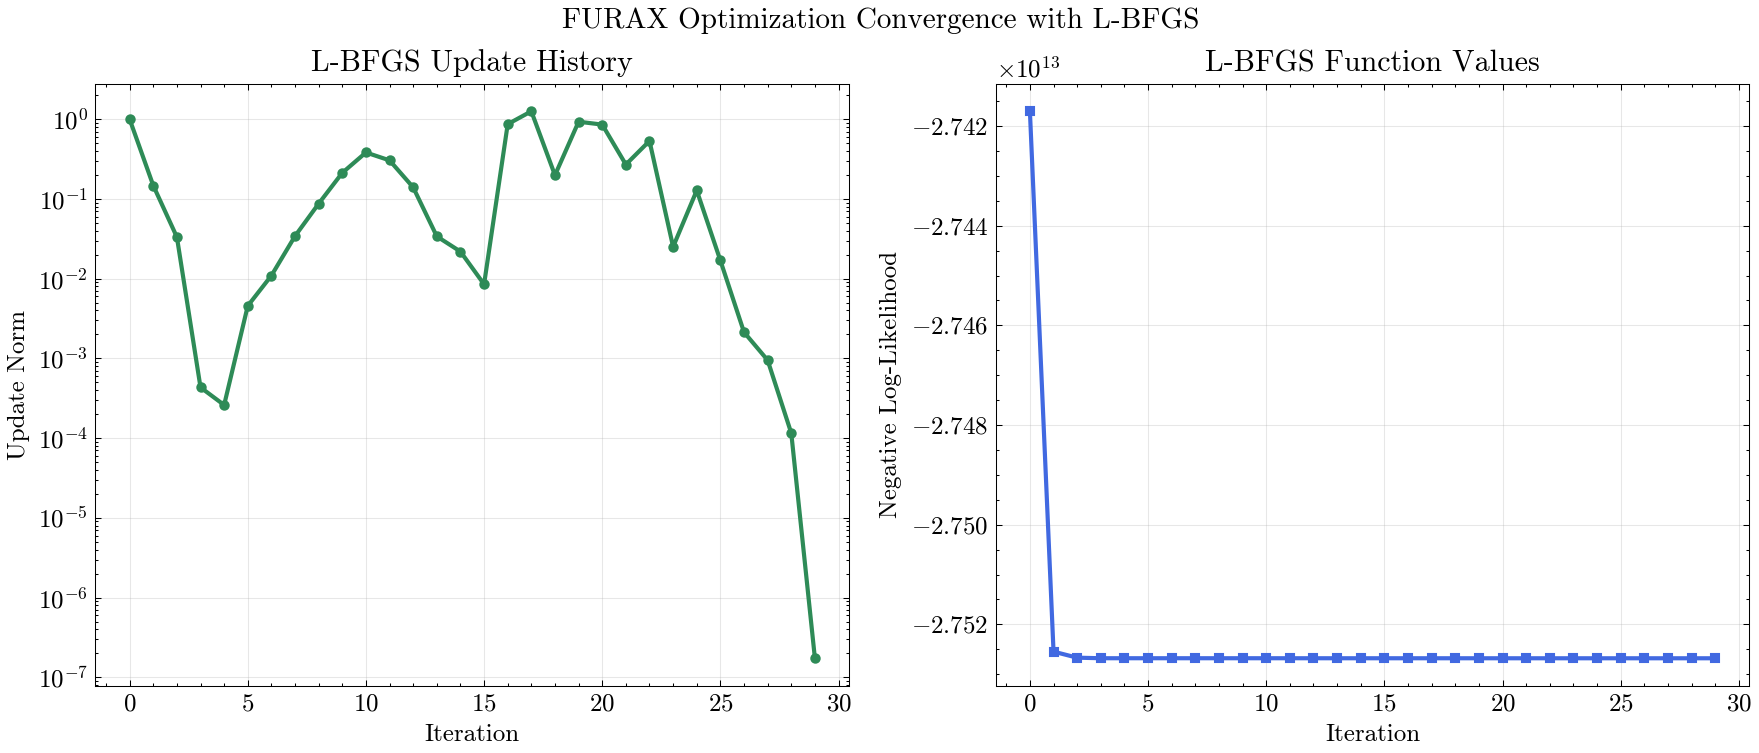


L-BFGS OPTIMIZATION SUMMARY
Total iterations: 30
Final function value: -2.75e+13
Final update norm: 1.73e-07
Convergence achieved: Yes


In [23]:
# L-BFGS Optimization History

# Set publication-quality plot style
plt.style.use(["science", "no-latex"])
plt.rcParams.update({"font.size": 12, "figure.dpi": 150})

# Create minimization history plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Extract update history from the final optimization state
update_history = np.array(final_state.update_history)
updates = update_history[:, 0]  # Update norms
values = update_history[:, 1]  # Function values (negative log-likelihood)

# Remove invalid zeros as done in the reference function
valid_mask = values != 0.0
updates_valid = updates[: len(valid_mask)][valid_mask]
values_valid = values[valid_mask]
iterations_valid = np.arange(len(updates_valid))

# Plot 1: Update Norms
ax1.plot(iterations_valid, updates_valid, "o-", color="#2E8B57", linewidth=2, markersize=4)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Update Norm")
ax1.set_title("L-BFGS Update History")
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# Plot 2: Function Values
ax2.plot(iterations_valid, values_valid, "s-", color="#4169E1", linewidth=2, markersize=4)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Negative Log-Likelihood")
ax2.set_title("L-BFGS Function Values")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("FURAX Optimization Convergence with L-BFGS", fontsize=14, fontweight="bold", y=1.02)
plt.show()

print("\n" + "=" * 50)
print("L-BFGS OPTIMIZATION SUMMARY")
print("=" * 50)
print(f"Total iterations: {len(values_valid)}")
print(f"Final function value: {values_valid[-1]:.2e}")
print(f"Final update norm: {updates_valid[-1]:.2e}")
print(f"Convergence achieved: {'Yes' if updates_valid[-1] < 1e-6 else 'No'}")
print("=" * 50)